# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=35,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-22-21/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4777 | MulticlassF1Score=0.1264
Batch-30 : CrossEntropyLoss=2.4904 | MulticlassF1Score=0.1945
Batch-45 : CrossEntropyLoss=2.4990 | MulticlassF1Score=0.2145
Batch-60 : CrossEntropyLoss=2.4513 | MulticlassF1Score=0.2547
Batch-75 : CrossEntropyLoss=2.4240 | MulticlassF1Score=0.2938
Batch-90 : CrossEntropyLoss=2.3912 | MulticlassF1Score=0.3277
Batch-105: CrossEntropyLoss=2.3837 | MulticlassF1Score=0.3568
Batch-120: CrossEntropyLoss=2.3659 | MulticlassF1Score=0.3853
Batch-135: CrossEntropyLoss=2.3920 | MulticlassF1Score=0.4084
Batch-150: CrossEntropyLoss=2.3676 | MulticlassF1Score=0.4271
Batch-165: CrossEntropyLoss=2.3689 | MulticlassF1Score=0.4414
Batch-180: CrossEntropyLoss=2.3702 | MulticlassF1Score=0.4561
Batch-195: CrossEntropyLoss=2.3539 | MulticlassF1Score=0.4711
Batch-210: CrossEntropyLoss=2.3306 | MulticlassF1Score=0.4889
Batch-225: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.5079
Batch-226: CrossEntropyLoss=2.3345 | MulticlassF1Score=0.5087

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3321 | MulticlassF1Score=0.7804
Batch-30 : CrossEntropyLoss=2.3377 | MulticlassF1Score=0.7756
Batch-45 : CrossEntropyLoss=2.3277 | MulticlassF1Score=0.7761
Batch-60 : CrossEntropyLoss=2.3165 | MulticlassF1Score=0.7753
Batch-63 : CrossEntropyLoss=2.3258 | MulticlassF1Score=0.7751

Training   : Mean CrossEntropyLoss = 2.4106 | Mean MulticlassF1Score = 0.3441
Validation : Mean CrossEntropyLoss = 2.3202 | Mean MulticlassF1Score = 0.7788

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3267 | MulticlassF1Score=0.7699
Batch-30 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7797
Batch-45 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7814
Batch-60 : CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7819
Batch-75 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7833
Batch-90 : CrossEntropyLoss=2.3206 | MulticlassF1Score=0.7852
Batch-105: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.7850
Batch-120: CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7845
Batch-135: CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7848
Batch-150: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7852
Batch-165: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.7850
Batch-180: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7850
Batch-195: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7861
Batch-210: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7865
Batch-225: CrossEntropyLoss=2.3188 | MulticlassF1Score=0.7869
Batch-226: CrossEntropyLoss=2.3241 | MulticlassF1Score=0.7869

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.7966
Batch-30 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7940
Batch-45 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7933
Batch-60 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7924
Batch-63 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7919

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3148 | Mean MulticlassF1Score = 0.7825
Validation : Mean CrossEntropyLoss = 2.3126 | Mean MulticlassF1Score = 0.7934

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7887
Batch-30 : CrossEntropyLoss=2.3189 | MulticlassF1Score=0.7881
Batch-45 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.7896
Batch-60 : CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7895
Batch-75 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7901
Batch-90 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.7912
Batch-105: CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7920
Batch-120: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7931
Batch-135: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.7935
Batch-150: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7943
Batch-165: CrossEntropyLoss=2.3108 | MulticlassF1Score=0.7957
Batch-180: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.7976
Batch-195: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.7995
Batch-210: CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8013
Batch-225: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8034
Batch-226: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8034

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8240
Batch-30 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8230
Batch-45 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8238
Batch-60 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8251
Batch-63 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8249

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3091 | Mean MulticlassF1Score = 0.7933
Validation : Mean CrossEntropyLoss = 2.3023 | Mean MulticlassF1Score = 0.8237

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8302
Batch-30 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8264
Batch-45 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8267
Batch-60 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8278
Batch-75 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8275
Batch-90 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8285
Batch-105: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8278
Batch-120: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8280
Batch-135: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8275
Batch-150: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8283
Batch-165: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8288
Batch-180: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8286
Batch-195: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8285
Batch-210: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8281
Batch-225: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8279
Batch-226: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8279

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8329
Batch-30 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8306
Batch-45 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8296
Batch-60 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8278
Batch-63 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8280
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8306

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8333
Batch-30 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8313
Batch-45 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8320
Batch-60 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8308
Batch-75 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8310
Batch-90 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8308
Batch-105: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8311
Batch-120: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8311
Batch-135: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8309
Batch-150: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8303
Batch-165: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8315
Batch-180: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8321
Batch-195: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8324
Batch-210: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8332
Batch-225: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8335
Batch-226: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8335

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8390
Batch-30 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8375
Batch-45 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8369
Batch-60 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8374
Batch-63 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8374

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2994 | Mean MulticlassF1Score = 0.8317
Validation : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8397

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8473
Batch-30 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8471
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8442
Batch-60 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8437
Batch-75 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8423
Batch-90 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8428
Batch-105: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8420
Batch-120: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8421
Batch-135: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8422
Batch-150: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8418
Batch-165: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8415
Batch-180: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8417
Batch-195: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8419
Batch-210: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8421
Batch-225: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8431
Batch-226: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8524
Batch-30 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8510
Batch-45 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8519
Batch-60 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8517
Batch-63 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8516

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8430
Validation : Mean CrossEntropyLoss = 2.2939 | Mean MulticlassF1Score = 0.8526

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8717
Batch-30 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8732
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8757
Batch-60 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8773
Batch-75 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8778
Batch-90 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8784
Batch-105: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8788
Batch-120: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8793
Batch-135: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8796
Batch-150: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8801
Batch-165: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8804
Batch-180: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8802
Batch-195: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8798
Batch-210: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8799
Batch-225: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8797
Batch-226: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8798

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8738
Batch-30 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8765
Batch-45 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8787
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8778
Batch-63 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8779

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2854 | Mean MulticlassF1Score = 0.8775
Validation : Mean CrossEntropyLoss = 2.2857 | Mean MulticlassF1Score = 0.8768

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8841
Batch-30 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8832
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8834
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8839
Batch-75 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8835
Batch-90 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8838
Batch-105: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8845
Batch-120: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8842
Batch-135: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8846
Batch-150: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8848
Batch-165: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8850
Batch-180: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8853
Batch-195: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8859
Batch-210: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8862
Batch-225: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8862
Batch-226: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8862

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8834
Batch-30 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8826
Batch-45 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8823
Batch-60 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8817
Batch-63 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8820

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8843
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8822

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8929
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8908
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8917
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8909
Batch-75 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8907
Batch-90 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8908
Batch-105: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8901
Batch-120: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8898
Batch-135: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8896
Batch-150: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8891
Batch-165: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8892
Batch-180: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8886
Batch-195: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8886
Batch-210: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8885
Batch-225: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8885
Batch-226: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8886

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8831
Batch-30 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8842
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8820
Batch-60 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8822
Batch-63 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8824

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8904
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8832

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8874
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8911
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8901
Batch-60 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8904
Batch-75 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8917
Batch-90 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8906
Batch-105: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8901
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8900
Batch-135: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8896
Batch-150: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8899
Batch-165: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8897
Batch-180: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8894
Batch-195: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8897
Batch-210: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8898
Batch-225: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8899
Batch-226: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8898

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8801
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8822
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8816
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8819
Batch-63 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8827

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8900
Validation : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8800

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8905
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8924
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8926
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8919
Batch-75 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8909
Batch-90 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8915
Batch-105: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.8914
Batch-120: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8911
Batch-135: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8915
Batch-150: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8916
Batch-165: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8913
Batch-180: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8909
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8919
Batch-210: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8935
Batch-225: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8952
Batch-226: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8953

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9080
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9051
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9060
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9068
Batch-63 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9064

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8916
Validation : Mean CrossEntropyLoss = 2.2770 | Mean MulticlassF1Score = 0.9059

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9160
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9167
Batch-45 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.9163
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9171
Batch-75 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9170
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9170
Batch-105: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9178
Batch-120: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9175
Batch-135: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9178
Batch-150: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9181
Batch-165: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9181
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9181
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9182
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9183
Batch-225: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9183
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9183

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9138
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9129
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9130
Batch-60 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9118
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9117

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9177
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9128

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9239
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9233
Batch-75 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9228
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9221
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9220
Batch-120: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9222
Batch-135: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9219
Batch-150: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9219
Batch-165: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9220
Batch-180: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9215
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9215
Batch-210: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9216
Batch-225: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9215
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9216

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9150
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9138
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9134
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9134
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9223
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9140

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9251
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9258
Batch-75 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9253
Batch-90 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9251
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9244
Batch-120: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9244
Batch-135: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9239
Batch-150: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9236
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9237
Batch-180: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9240
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9235
Batch-210: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9235
Batch-225: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9232
Batch-226: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9232

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9147
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9123
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9126
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9134
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9245
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9132

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9253
Batch-75 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9256
Batch-90 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9251
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9254
Batch-120: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9252
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9255
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9254
Batch-165: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9250
Batch-180: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9249
Batch-195: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9249
Batch-210: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9247
Batch-225: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9248
Batch-226: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9247

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9085
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9141
Batch-45 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9138
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9134
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9254
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9122

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9297
Batch-75 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9294
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9280
Batch-105: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.9275
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9272
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9271
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9270
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9273
Batch-180: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9266
Batch-195: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9268
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9266
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9265
Batch-226: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9265

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9130
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9136
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9139
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9151
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9149

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9271
Validation : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9140

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9292
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9286
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9293
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9293
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9293
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9287
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9289
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9282
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9280
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9277
Batch-180: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9278
Batch-195: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9276
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9276
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9275
Batch-226: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9275

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9153
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9167
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9157
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9153
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9150

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9285
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9149

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9317
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9323
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9297
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9287
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9293
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9292
Batch-105: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9292
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9292
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9292
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9294
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9300
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9301
Batch-195: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9300
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9300
Batch-225: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9301
Batch-226: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9301

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9182
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9185
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9183
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9181
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9184

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9298
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9186

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9370
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9340
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9339
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9340
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9334
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9329
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9330
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9330
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9330
Batch-150: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9331
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9325
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9328
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9329
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9329
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9330
Batch-226: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9330

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9165
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9200
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9193
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9196
Batch-63 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9194

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9335
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9187

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9355
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9324
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9318
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9321
Batch-75 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9327
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9330
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9335
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9338
Batch-150: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9337
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9337
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9334
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9338
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9338
Batch-225: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9339
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9339

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9155
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9177
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9190
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9195
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9195

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9332
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9179

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9380
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9366
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9360
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9363
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9361
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9363
Batch-150: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9362
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9362
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9361
Batch-195: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9360
Batch-210: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9357
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9355
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9355

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9173
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9165
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9197
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9194
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9200

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9367
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9178

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9345
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9363
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9365
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9355
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9359
Batch-105: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9358
Batch-120: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9360
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9366
Batch-150: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9364
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9367
Batch-180: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9369
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9376
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9376
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9377

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9364
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9233

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9414
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9405
Batch-165: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9401
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9402
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9403
Batch-210: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9403
Batch-225: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9402
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9402

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9408
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9229

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9423
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9430
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9425
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9421
Batch-120: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9423
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9425
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9421
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9419
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9417
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9416
Batch-225: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9418
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9418

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9235
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9247

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9422
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9257

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9418
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9417
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9428
Batch-105: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9427
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9425
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9428
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9427
Batch-210: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9426
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9425
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9247
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9250

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9264

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9442
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9443
Batch-90 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9431
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9429
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9432
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9429
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9430
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9430

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9437
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9273

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9432
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9450
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9446
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9447
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9448
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9446
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9446

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9262

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9464
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9465
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9462
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9454
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9457
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9457
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9458
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9460
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9286
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9290
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9295

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9484
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9481
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9466
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9470
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9471
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9257

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9474
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9478
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9478
Batch-105: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9473
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9474
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9475
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9476
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9469
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9469

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9299
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9289
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9477
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9290

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9470
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9475
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9477
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9479
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9481
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9479
Batch-195: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9478
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9474
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9319
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9302
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9279

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9296

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9523
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9511
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9489
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9491
Batch-90 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9489
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9487
Batch-120: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9486
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9484
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9484
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9485
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9485
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9482
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9284
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9490
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9273

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9511
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9505
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9503
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9494
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9488
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9489
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9493
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9492
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9493
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9487
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9489
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9488
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9487
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9485
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9485

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9322
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9295
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9283
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9284
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9289

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9494
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9300

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9534
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9518
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9505
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9494
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9491
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9489
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9487
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9486
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9486
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9488
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9486
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9487
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9485
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9485

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9299
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9286
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9287

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9494
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9264

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9496
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9496
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9499
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9500
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9499
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9494
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9495
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9492
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9490
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9491
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9492
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9490
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9490

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9306
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9273
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9500
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9282

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9501
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9502
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9504
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9500
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9500
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9499
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9497
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9493
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9494
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9494
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9493
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9492
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9492

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9251
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9297
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9294

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9500
Validation : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9273

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9494
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9494
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9494
Batch-105: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9489
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9493
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9496
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9497
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9495
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9494
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9496
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9496
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9496
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9496

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9282
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9285
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9288

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9495
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9282

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9527
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9520
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9521
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9517
Batch-75 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9513
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9511
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9511
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9506
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9504
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9503
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9504
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9504
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9501
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9499
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9497
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9497

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9284
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9292
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9289
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9289

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9510
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9277

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9481
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9483
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9480
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9483
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9483
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9487
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9487
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9489
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9490
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9490
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9488
Batch-226: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9488

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9293
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9291
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9284
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9284

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9483
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9282
Patience = 1/50❗

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9499
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9502
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9505
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9503
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9500
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9497
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9495
Batch-165: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9500
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9501
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9499
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9494
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9495
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9494

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9327
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9294
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9292
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9497
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9304

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9503
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9498
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9503
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9499
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9503
Batch-135: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9502
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9505
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9503
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9503
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9503
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9501
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9500
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9500

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9321
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9311
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9292
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9293
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9293

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9500
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9313

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9509
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9501
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9493
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9501
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9505
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9501
Batch-135: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9503
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9501
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9503
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9502
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9502
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9501
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9501
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9501

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9288
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2628 | Mean MulticlassF1Score = 0.9502
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9270

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9503
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9509
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9508
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9509
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9506
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9507
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9506
Batch-165: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9505
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9505
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9505
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9502
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9502
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9503

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9268
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9295
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9294
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2628 | Mean MulticlassF1Score = 0.9502
Validation : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9278

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9505
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9502
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9505
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9504
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9506
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9507
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9506
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9510
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9508
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9508
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9510
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9510
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9509
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9508

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9306
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9288
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9289

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9504
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9297

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9525
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9514
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9515
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9510
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9510
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9510
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9509
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9506
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9507
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9508
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9510
Batch-180: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9512
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9510
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9511
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9508
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9508

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9283

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9511
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9268
Patience = 2/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9511
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9518
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9510
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9512
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9509
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9507
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9506
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9502
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9503
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9502
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9501
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9502
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9503
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9503
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9503

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9297
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9290

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2628 | Mean MulticlassF1Score = 0.9507
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9281
Patience = 3/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9496
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9505
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9511
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9513
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9512
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9513
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9512
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9512
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9511
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9513
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9511
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9507
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9507

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9299
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9291
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9295
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9296

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9510
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9300

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9521
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9505
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9520
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9525
Batch-75 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9525
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9520
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9519
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9520
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9520
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9517
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9520
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9518
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9516
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9512
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9512
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9512

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9310
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9292
Batch-63 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9290

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2625 | Mean MulticlassF1Score = 0.9518
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9293

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9510
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9497
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9500
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9500
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9506
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9508
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9510
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9509
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9510
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9512
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9510
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9514
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9514
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9514

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9288
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9289

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2624 | Mean MulticlassF1Score = 0.9504
Validation : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9271

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9505
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9561
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9596
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9637
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9645
Batch-120: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9653
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9659
Batch-150: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9668
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9622
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9477

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2575
Best CrossEntropyLoss training    : 2.2635
Best MulticlassF1Score validation : 0.9622
Best MulticlassF1Score validation : 0.9477
Training duration                 : 3.6359 minutes.
Training date                     : 2022-10-19 09:54:18.252691+08:00


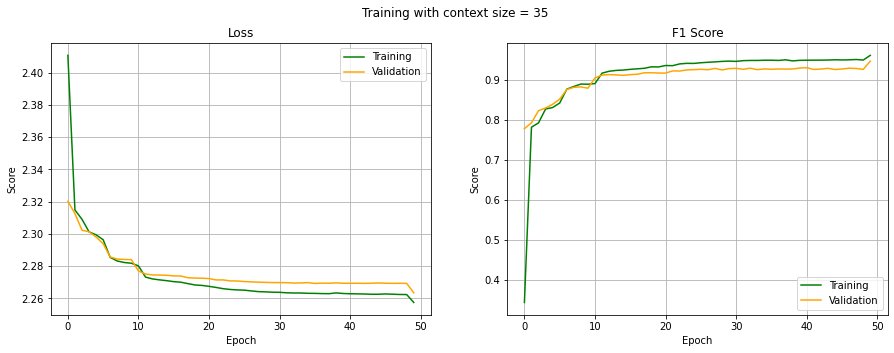

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9711, device='cuda:0'),
 tensor(0.9484, device='cuda:0'),
 tensor(0.9466, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9711, device='cuda:0'),
 tensor(0.9484, device='cuda:0'),
 tensor(0.9466, device='cuda:0'))

## Heatmap

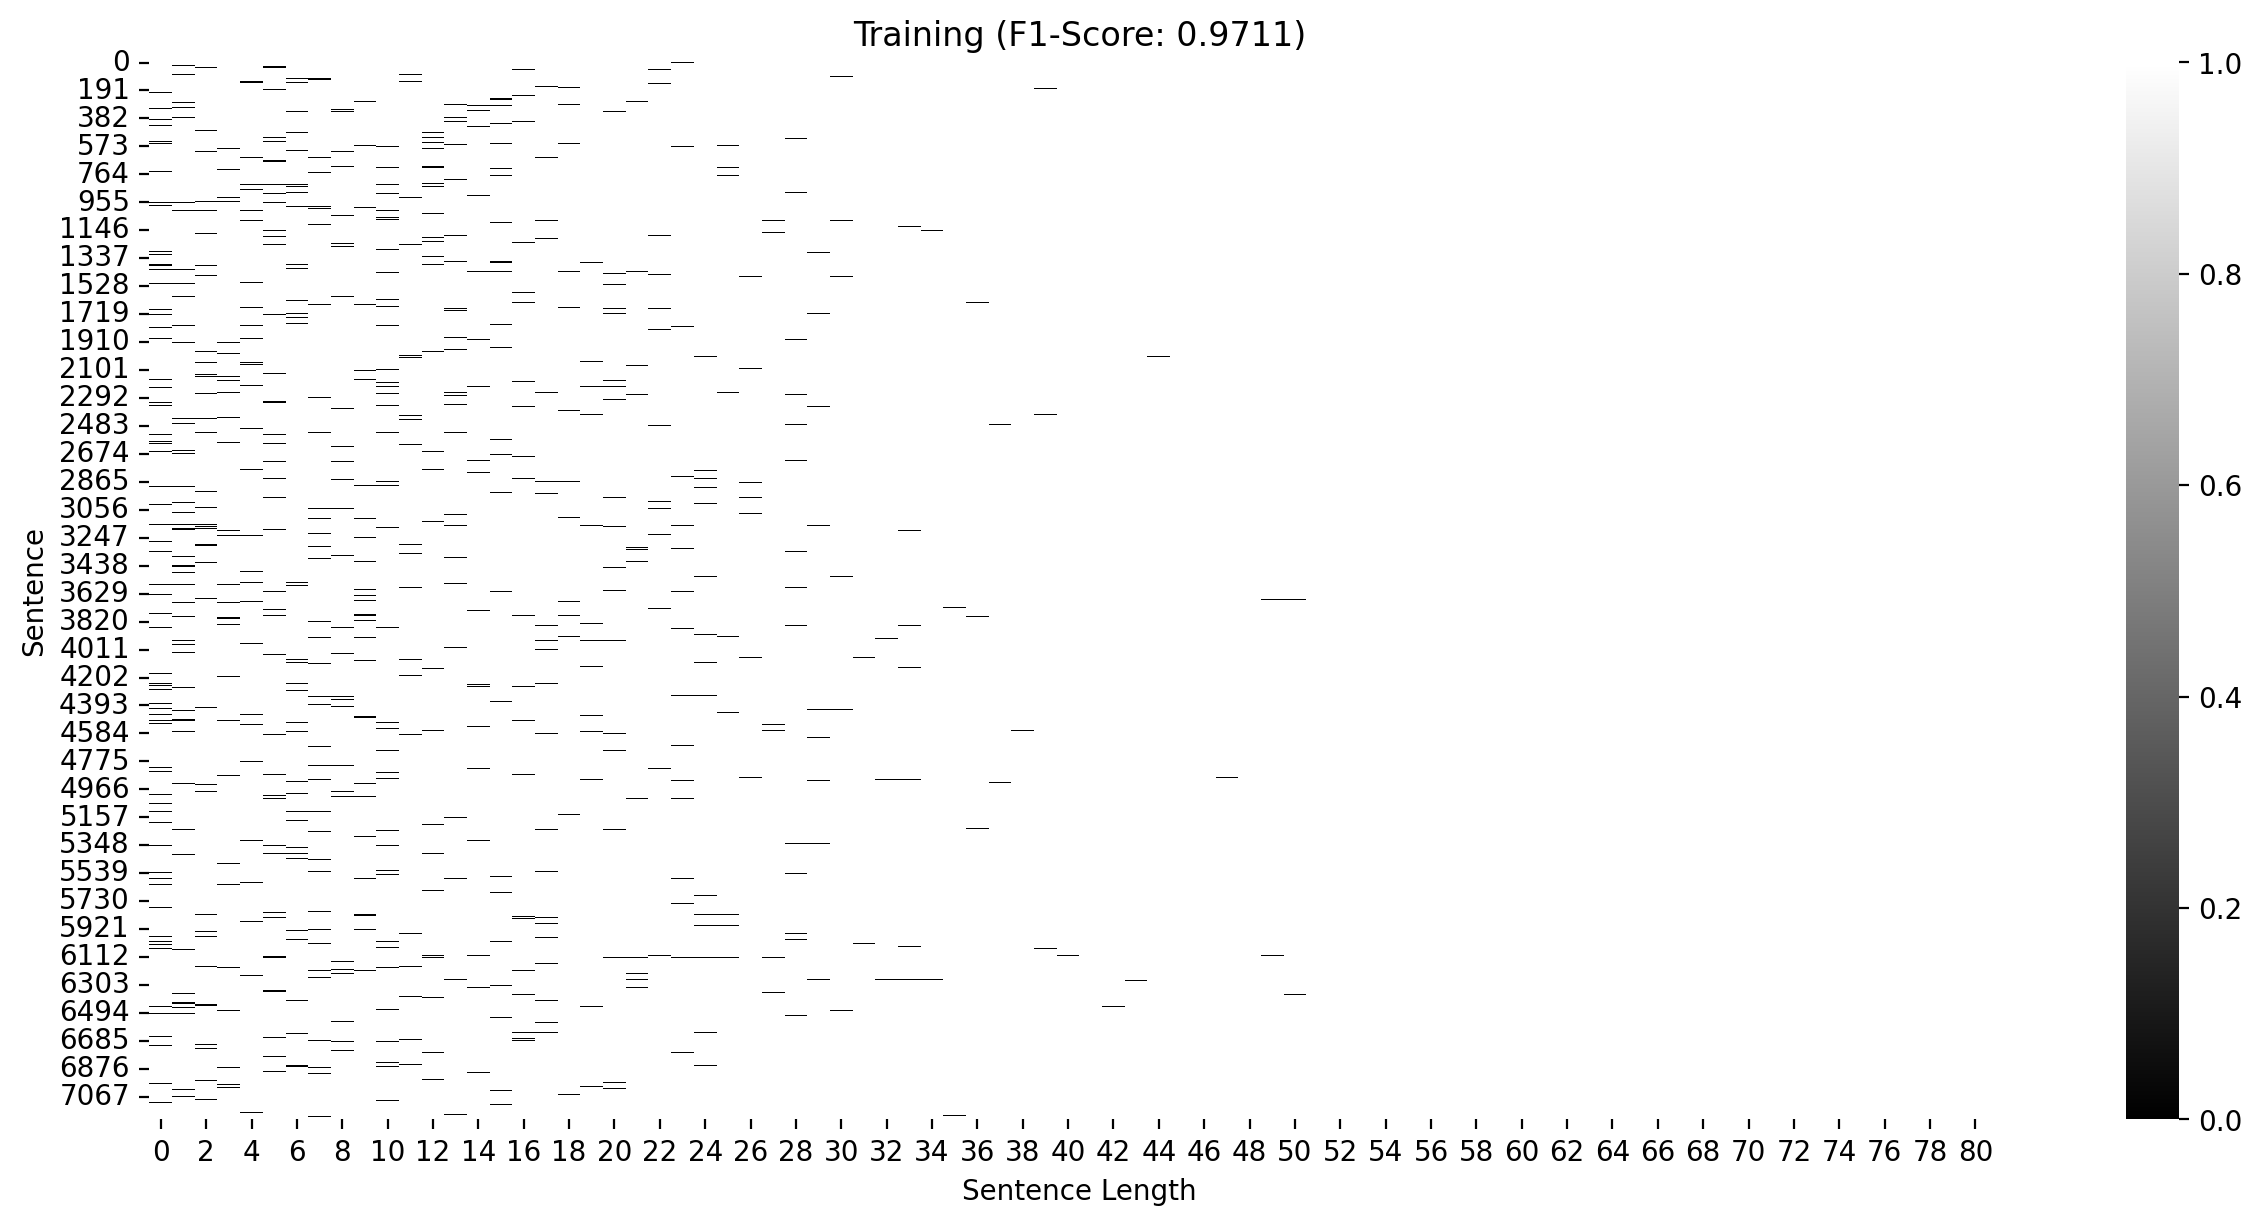

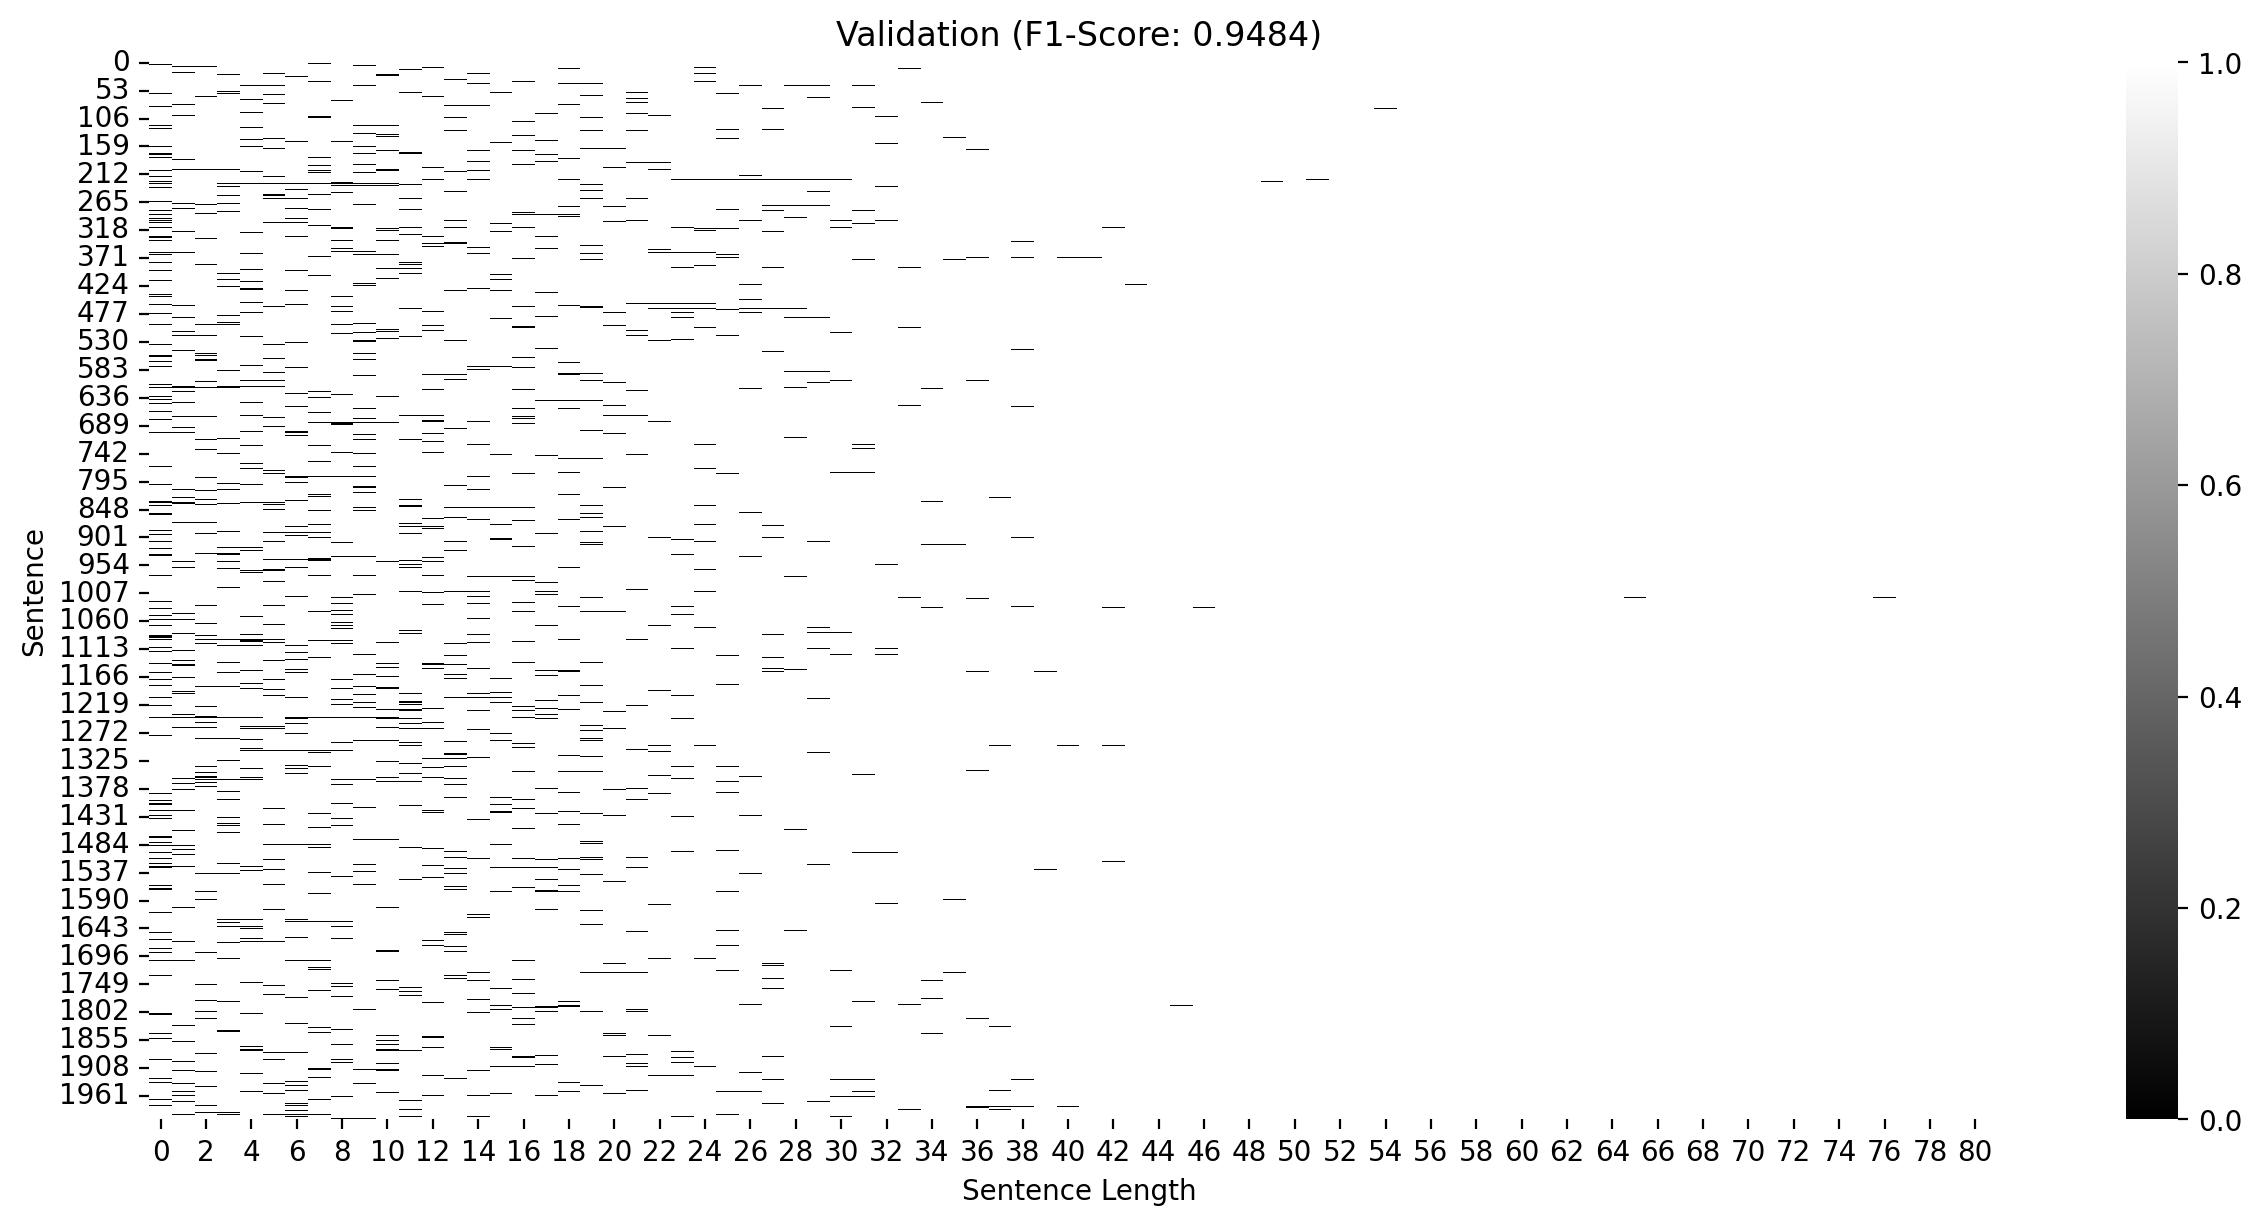

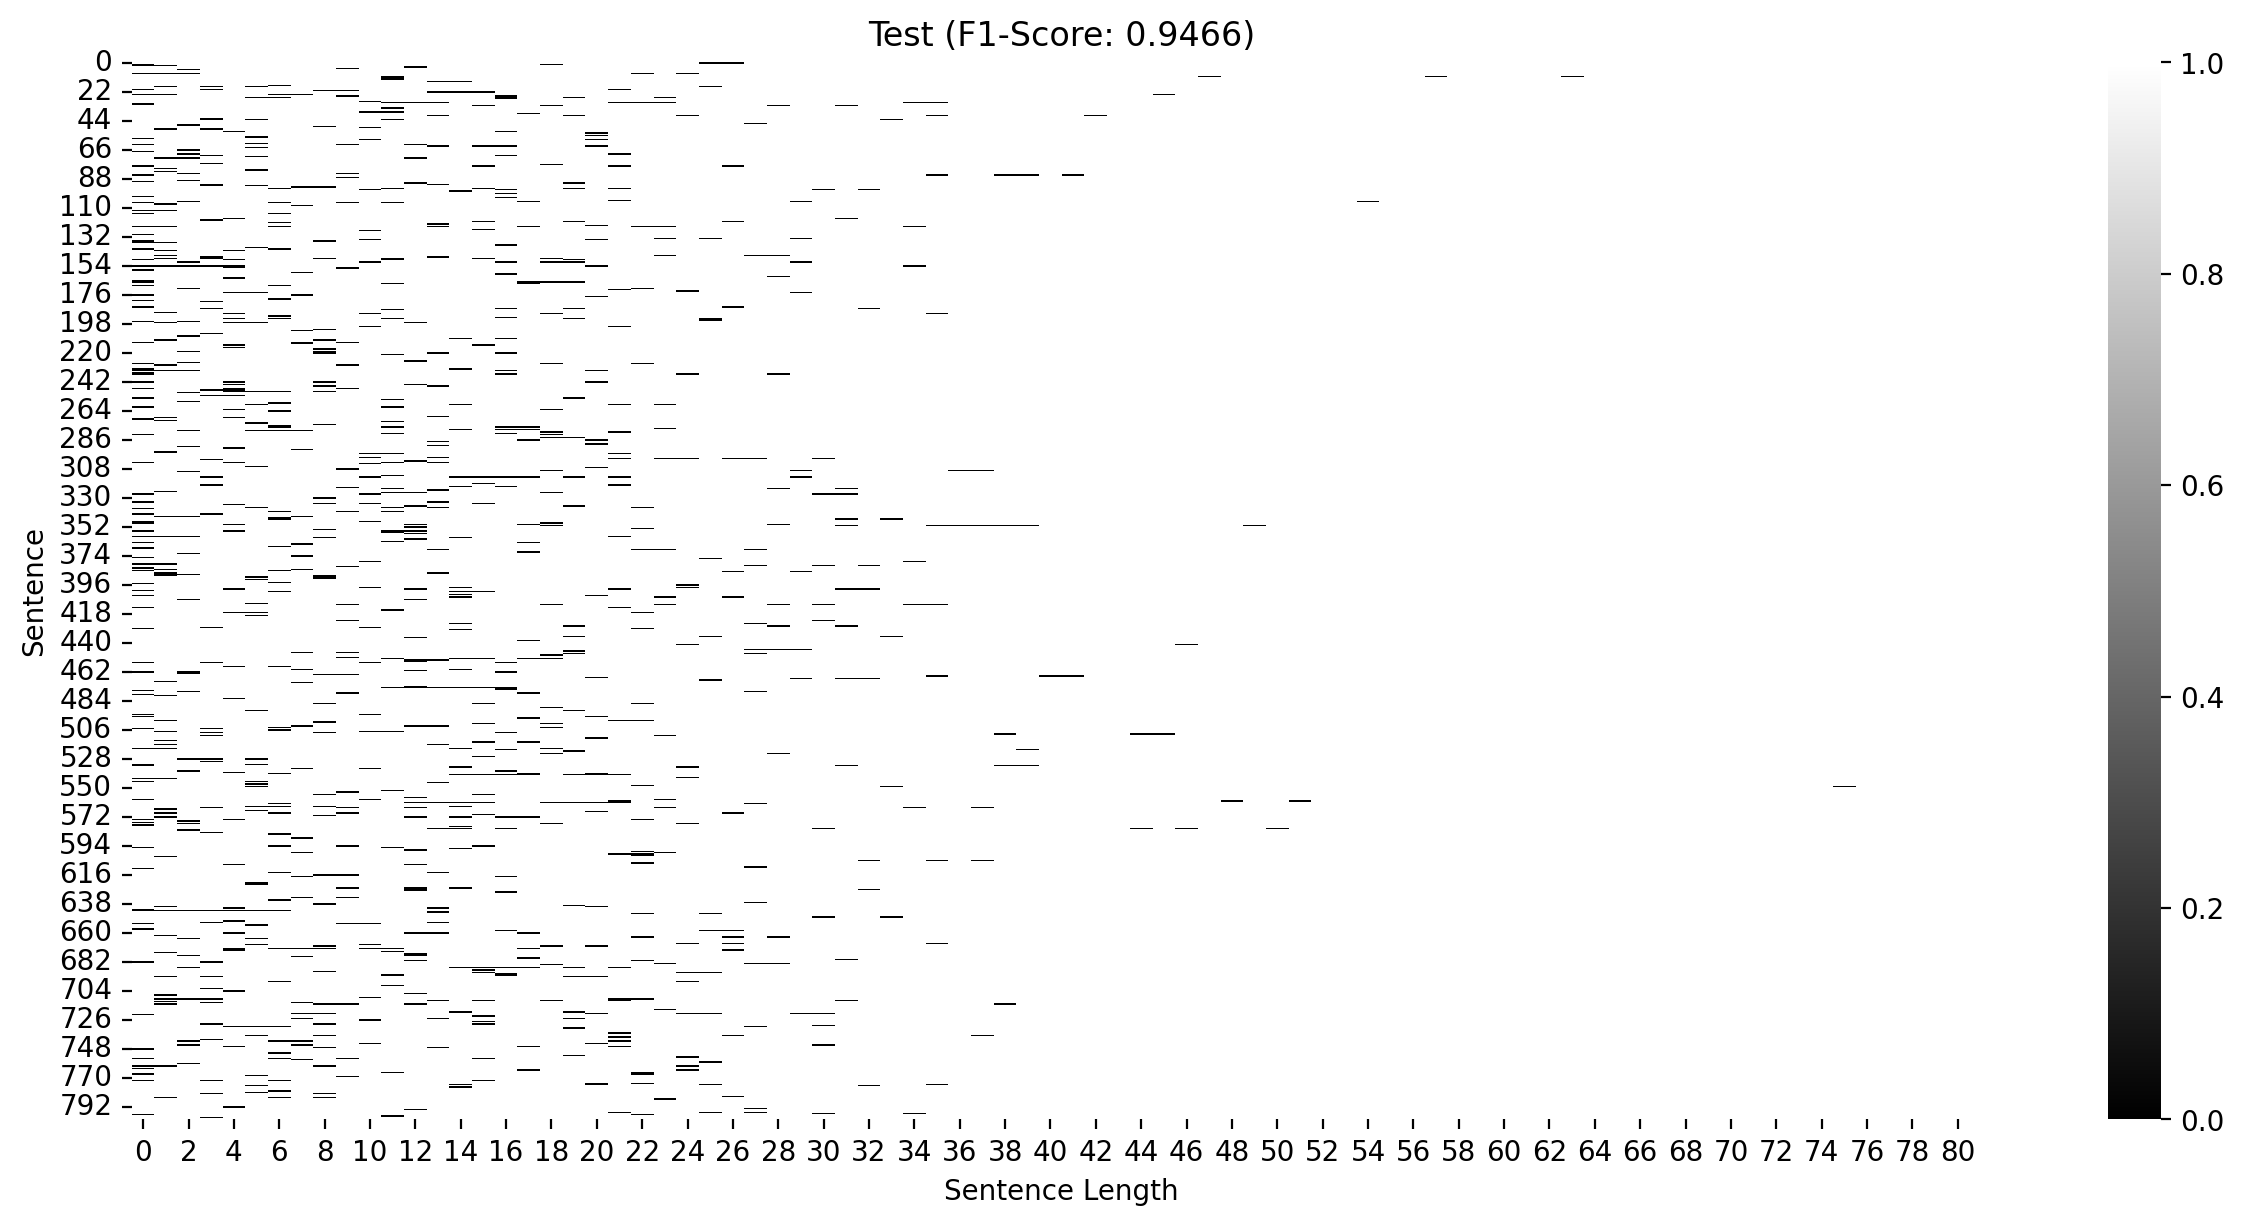

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


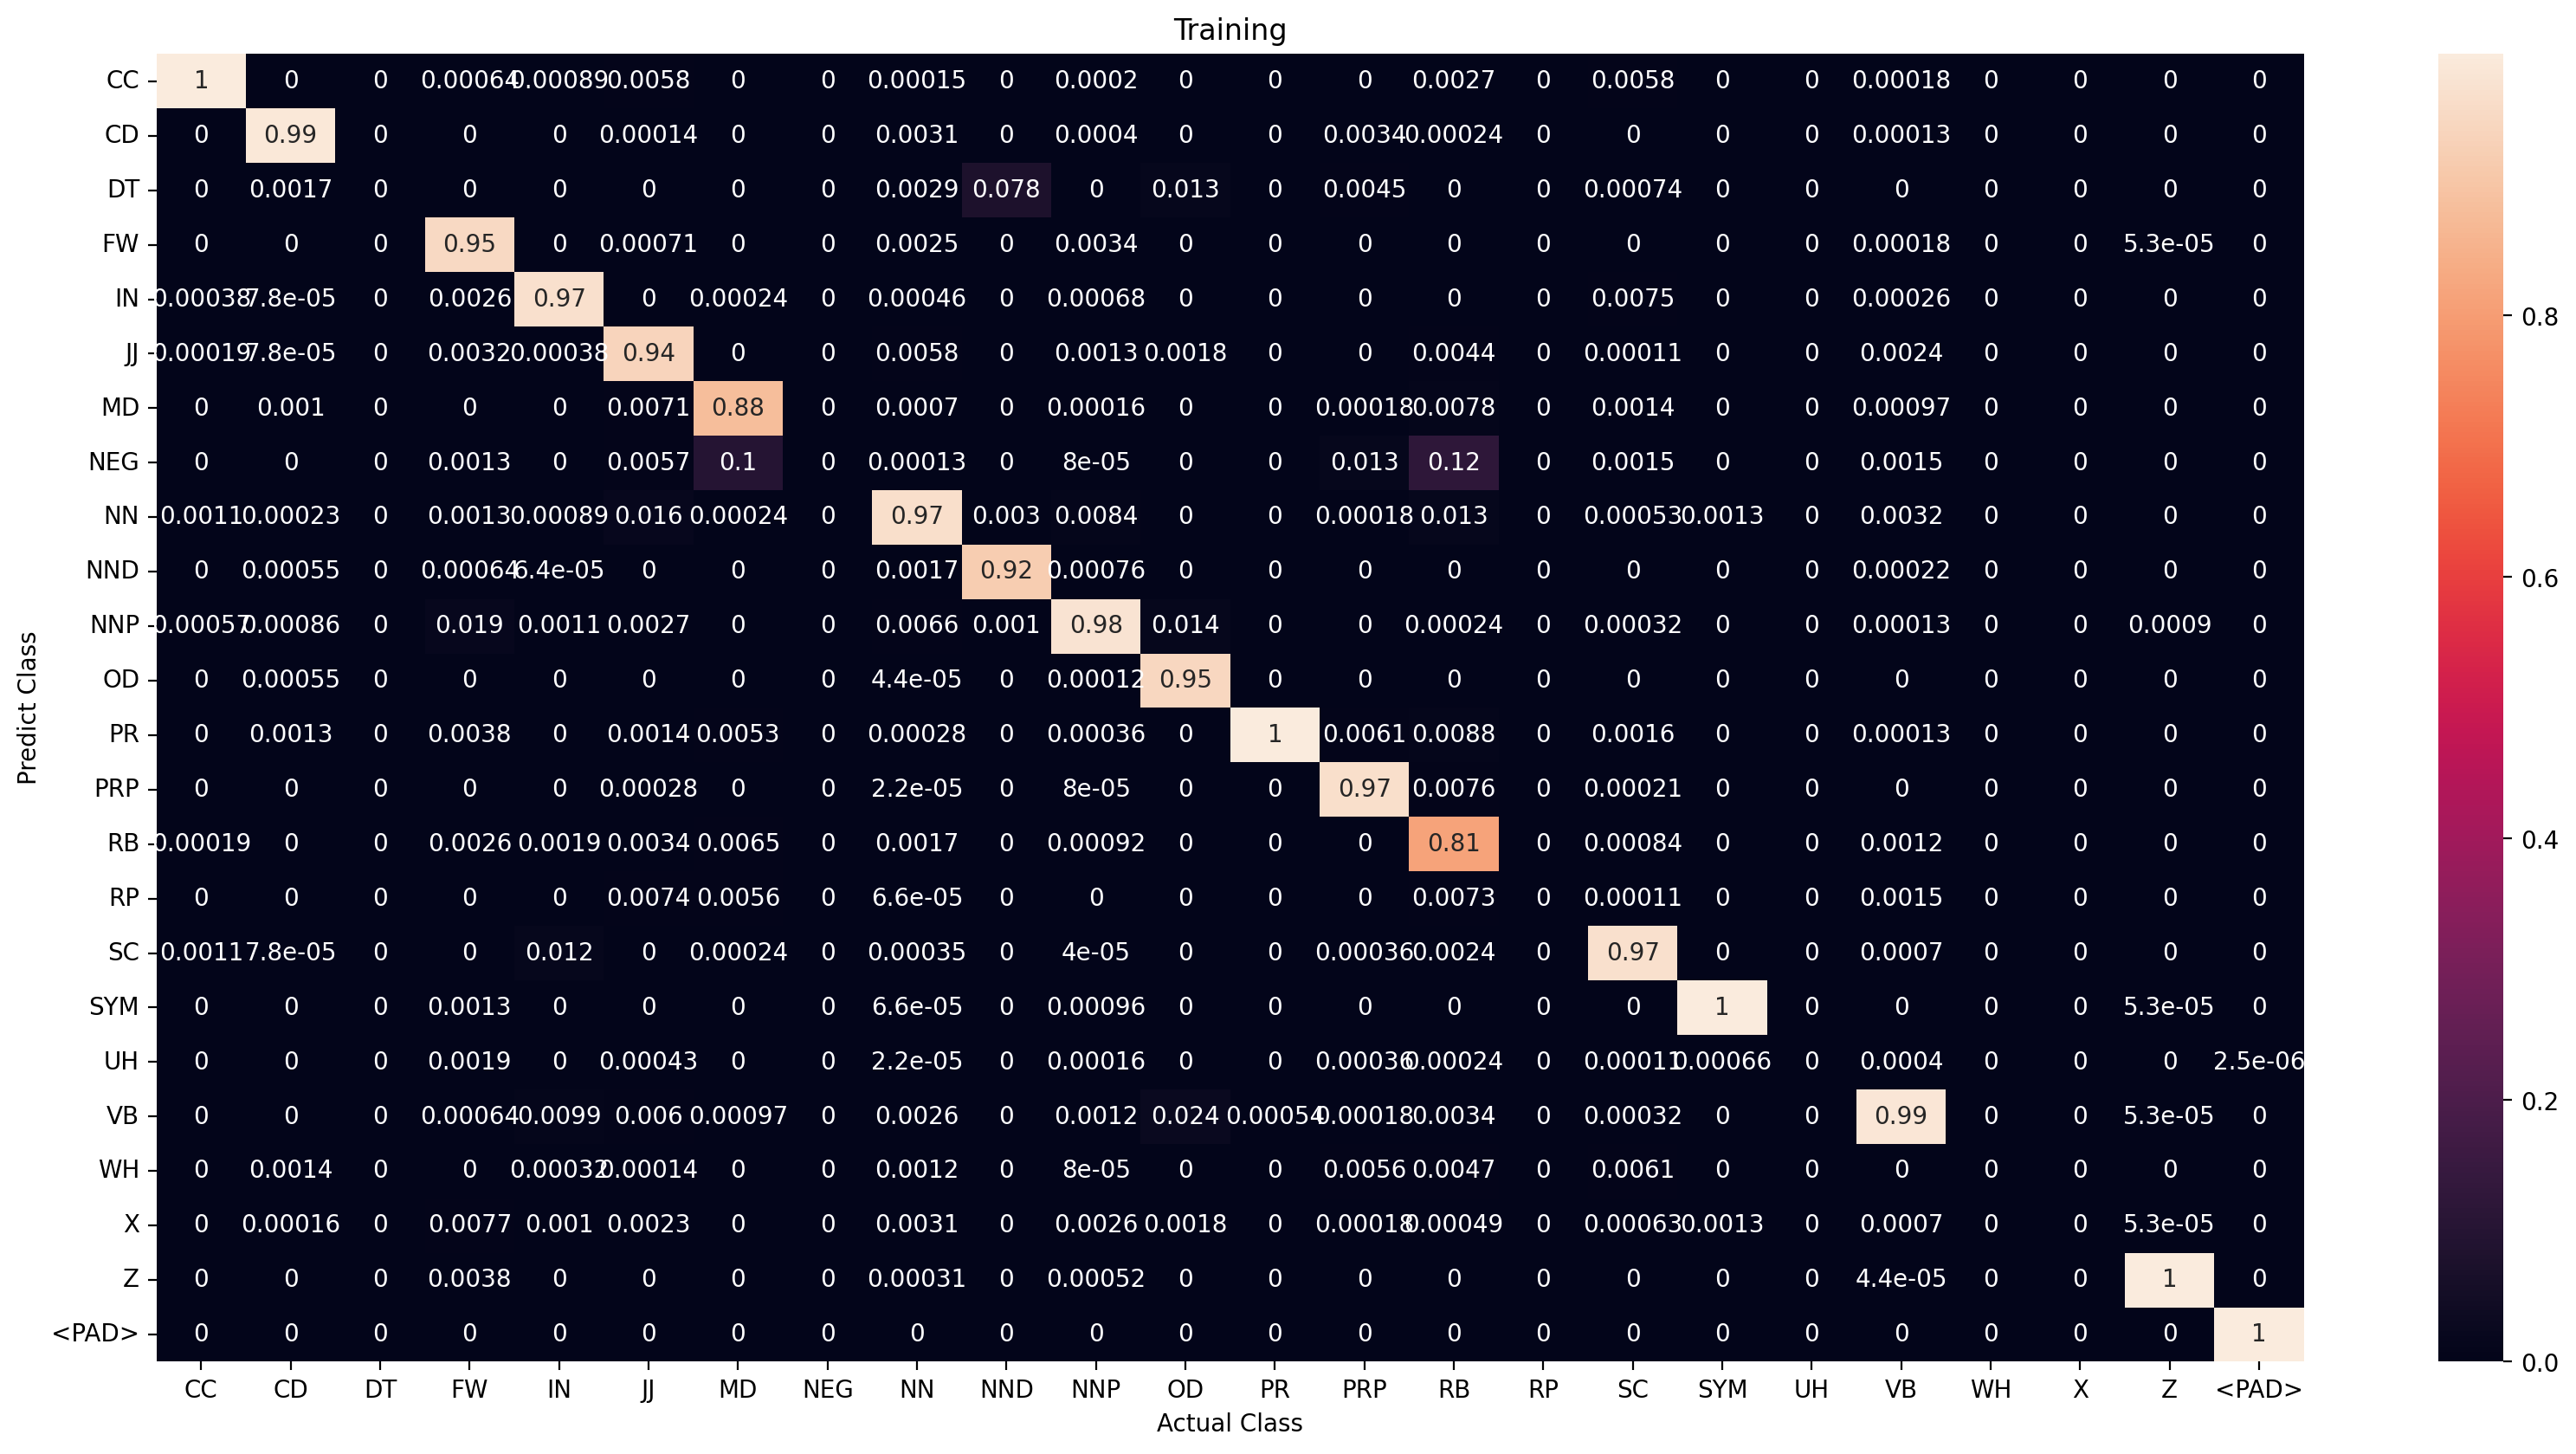

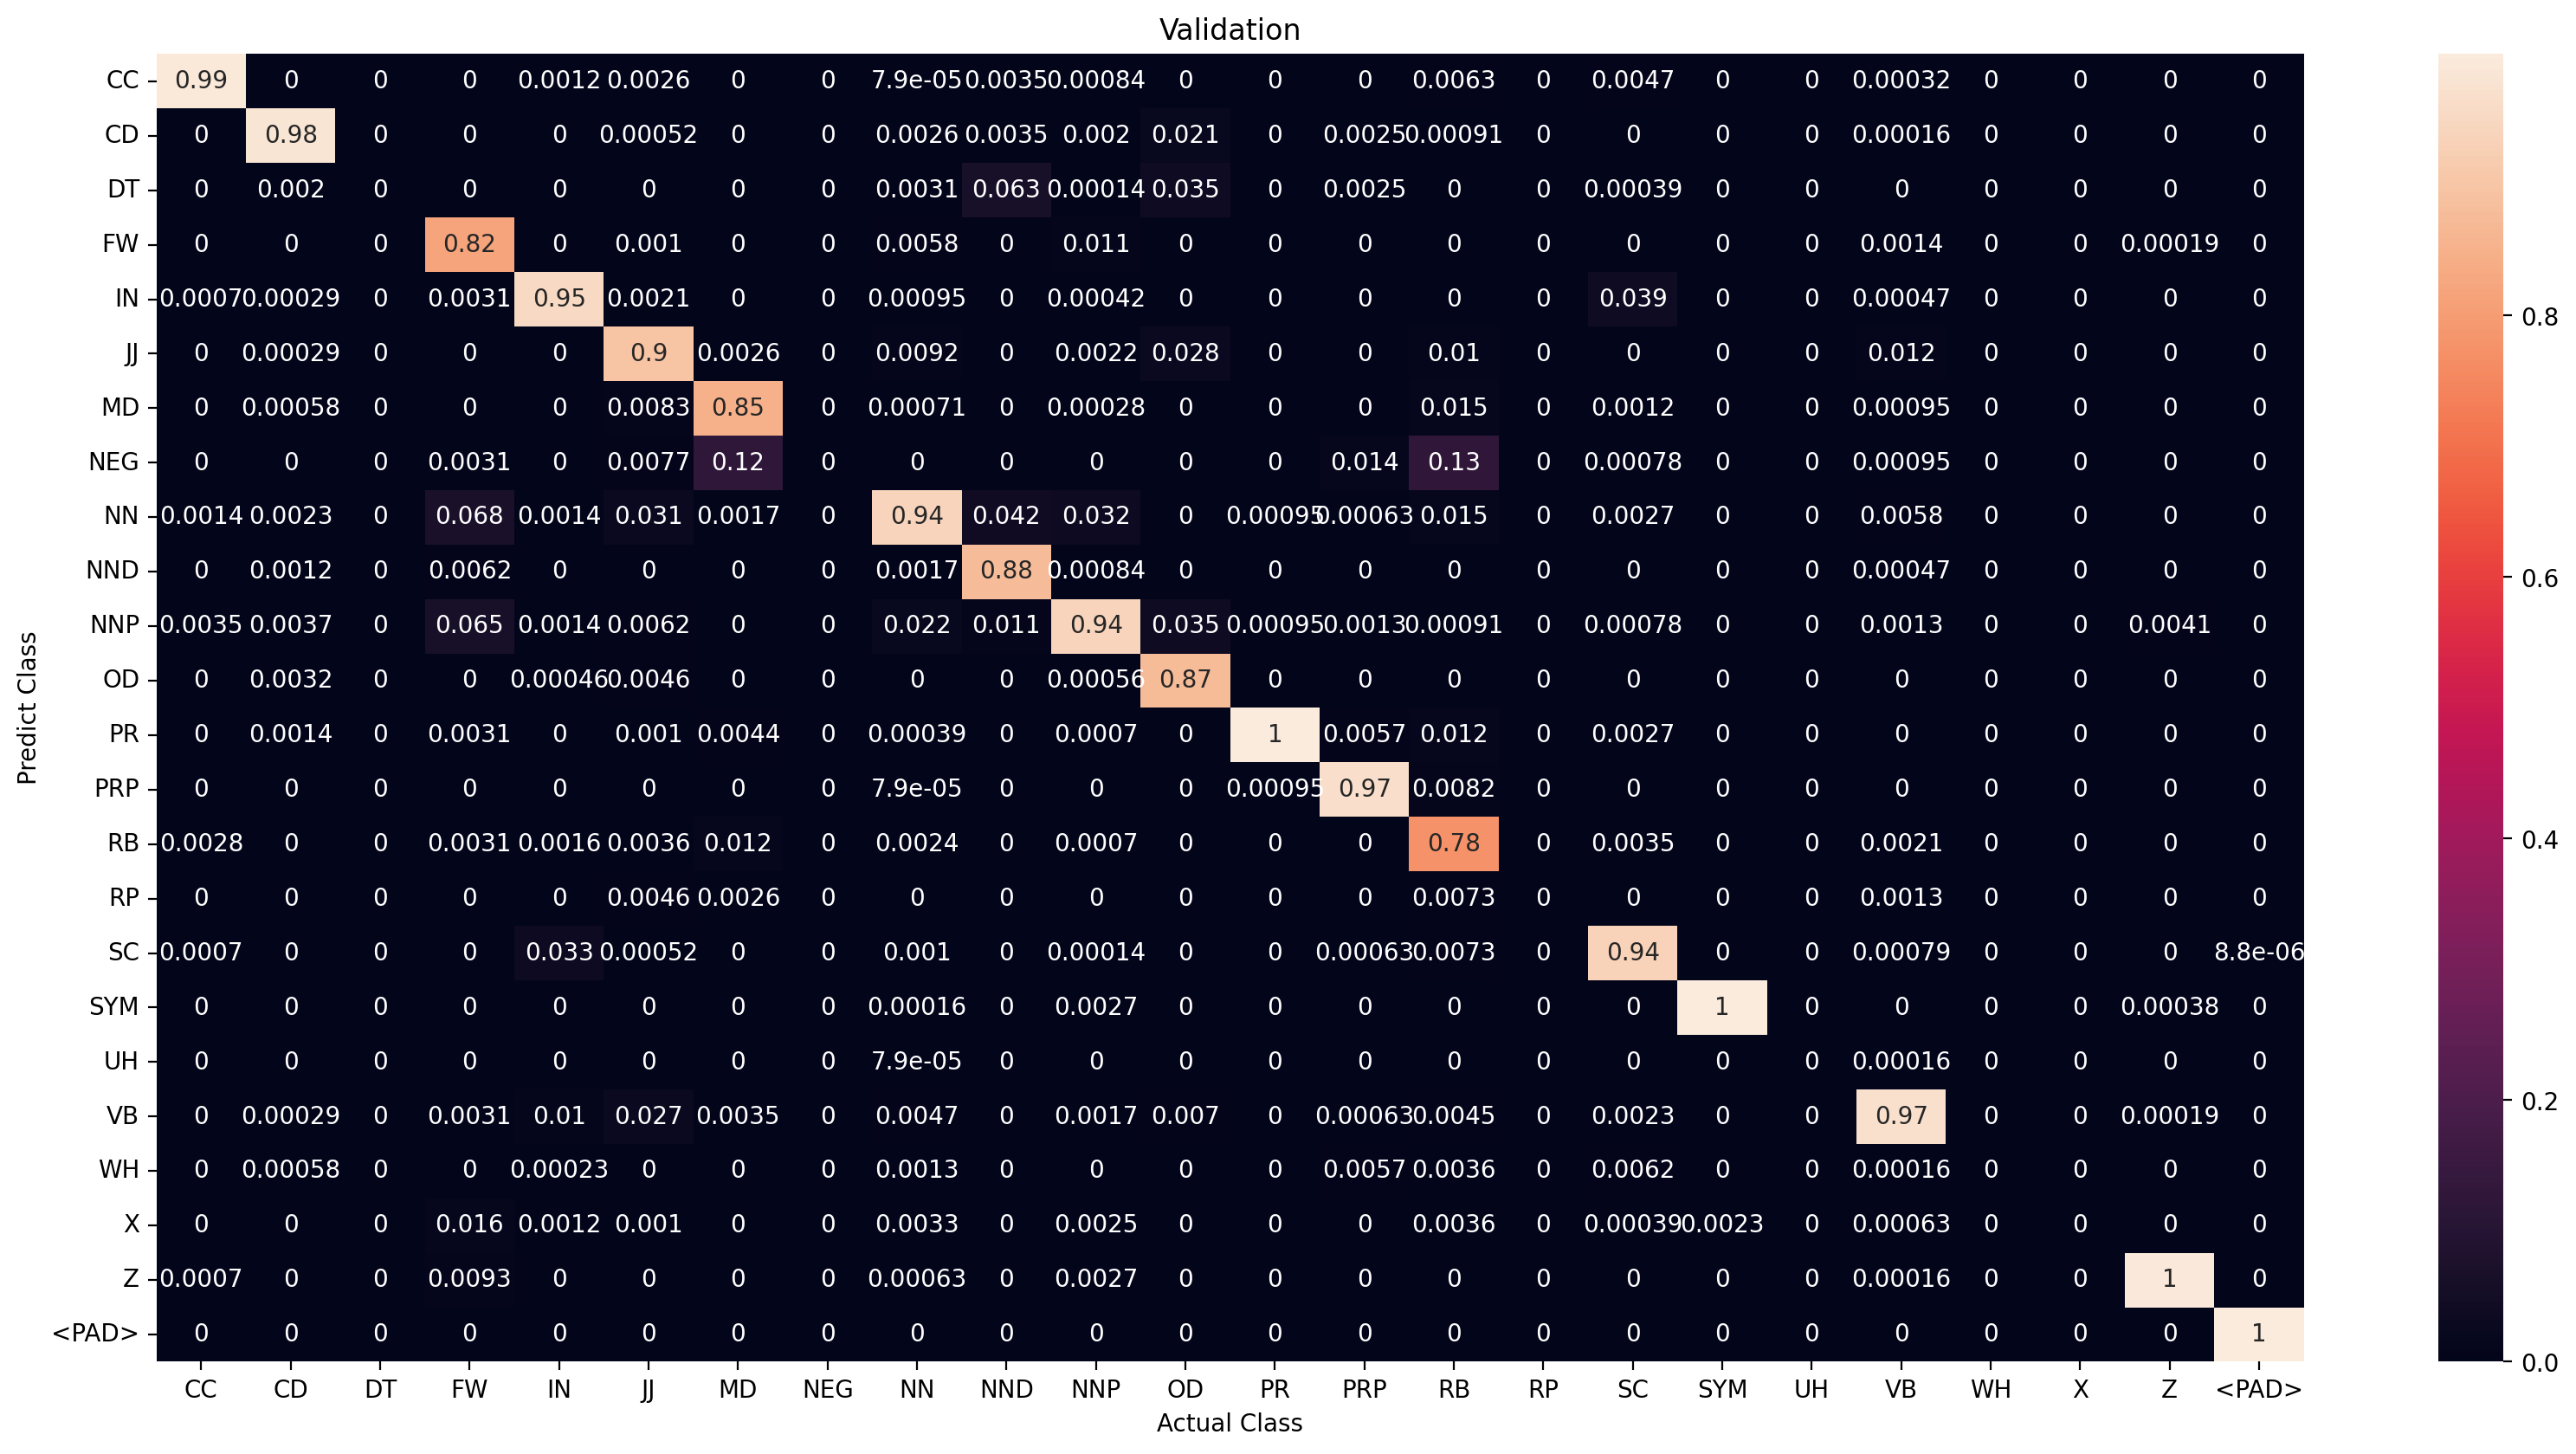

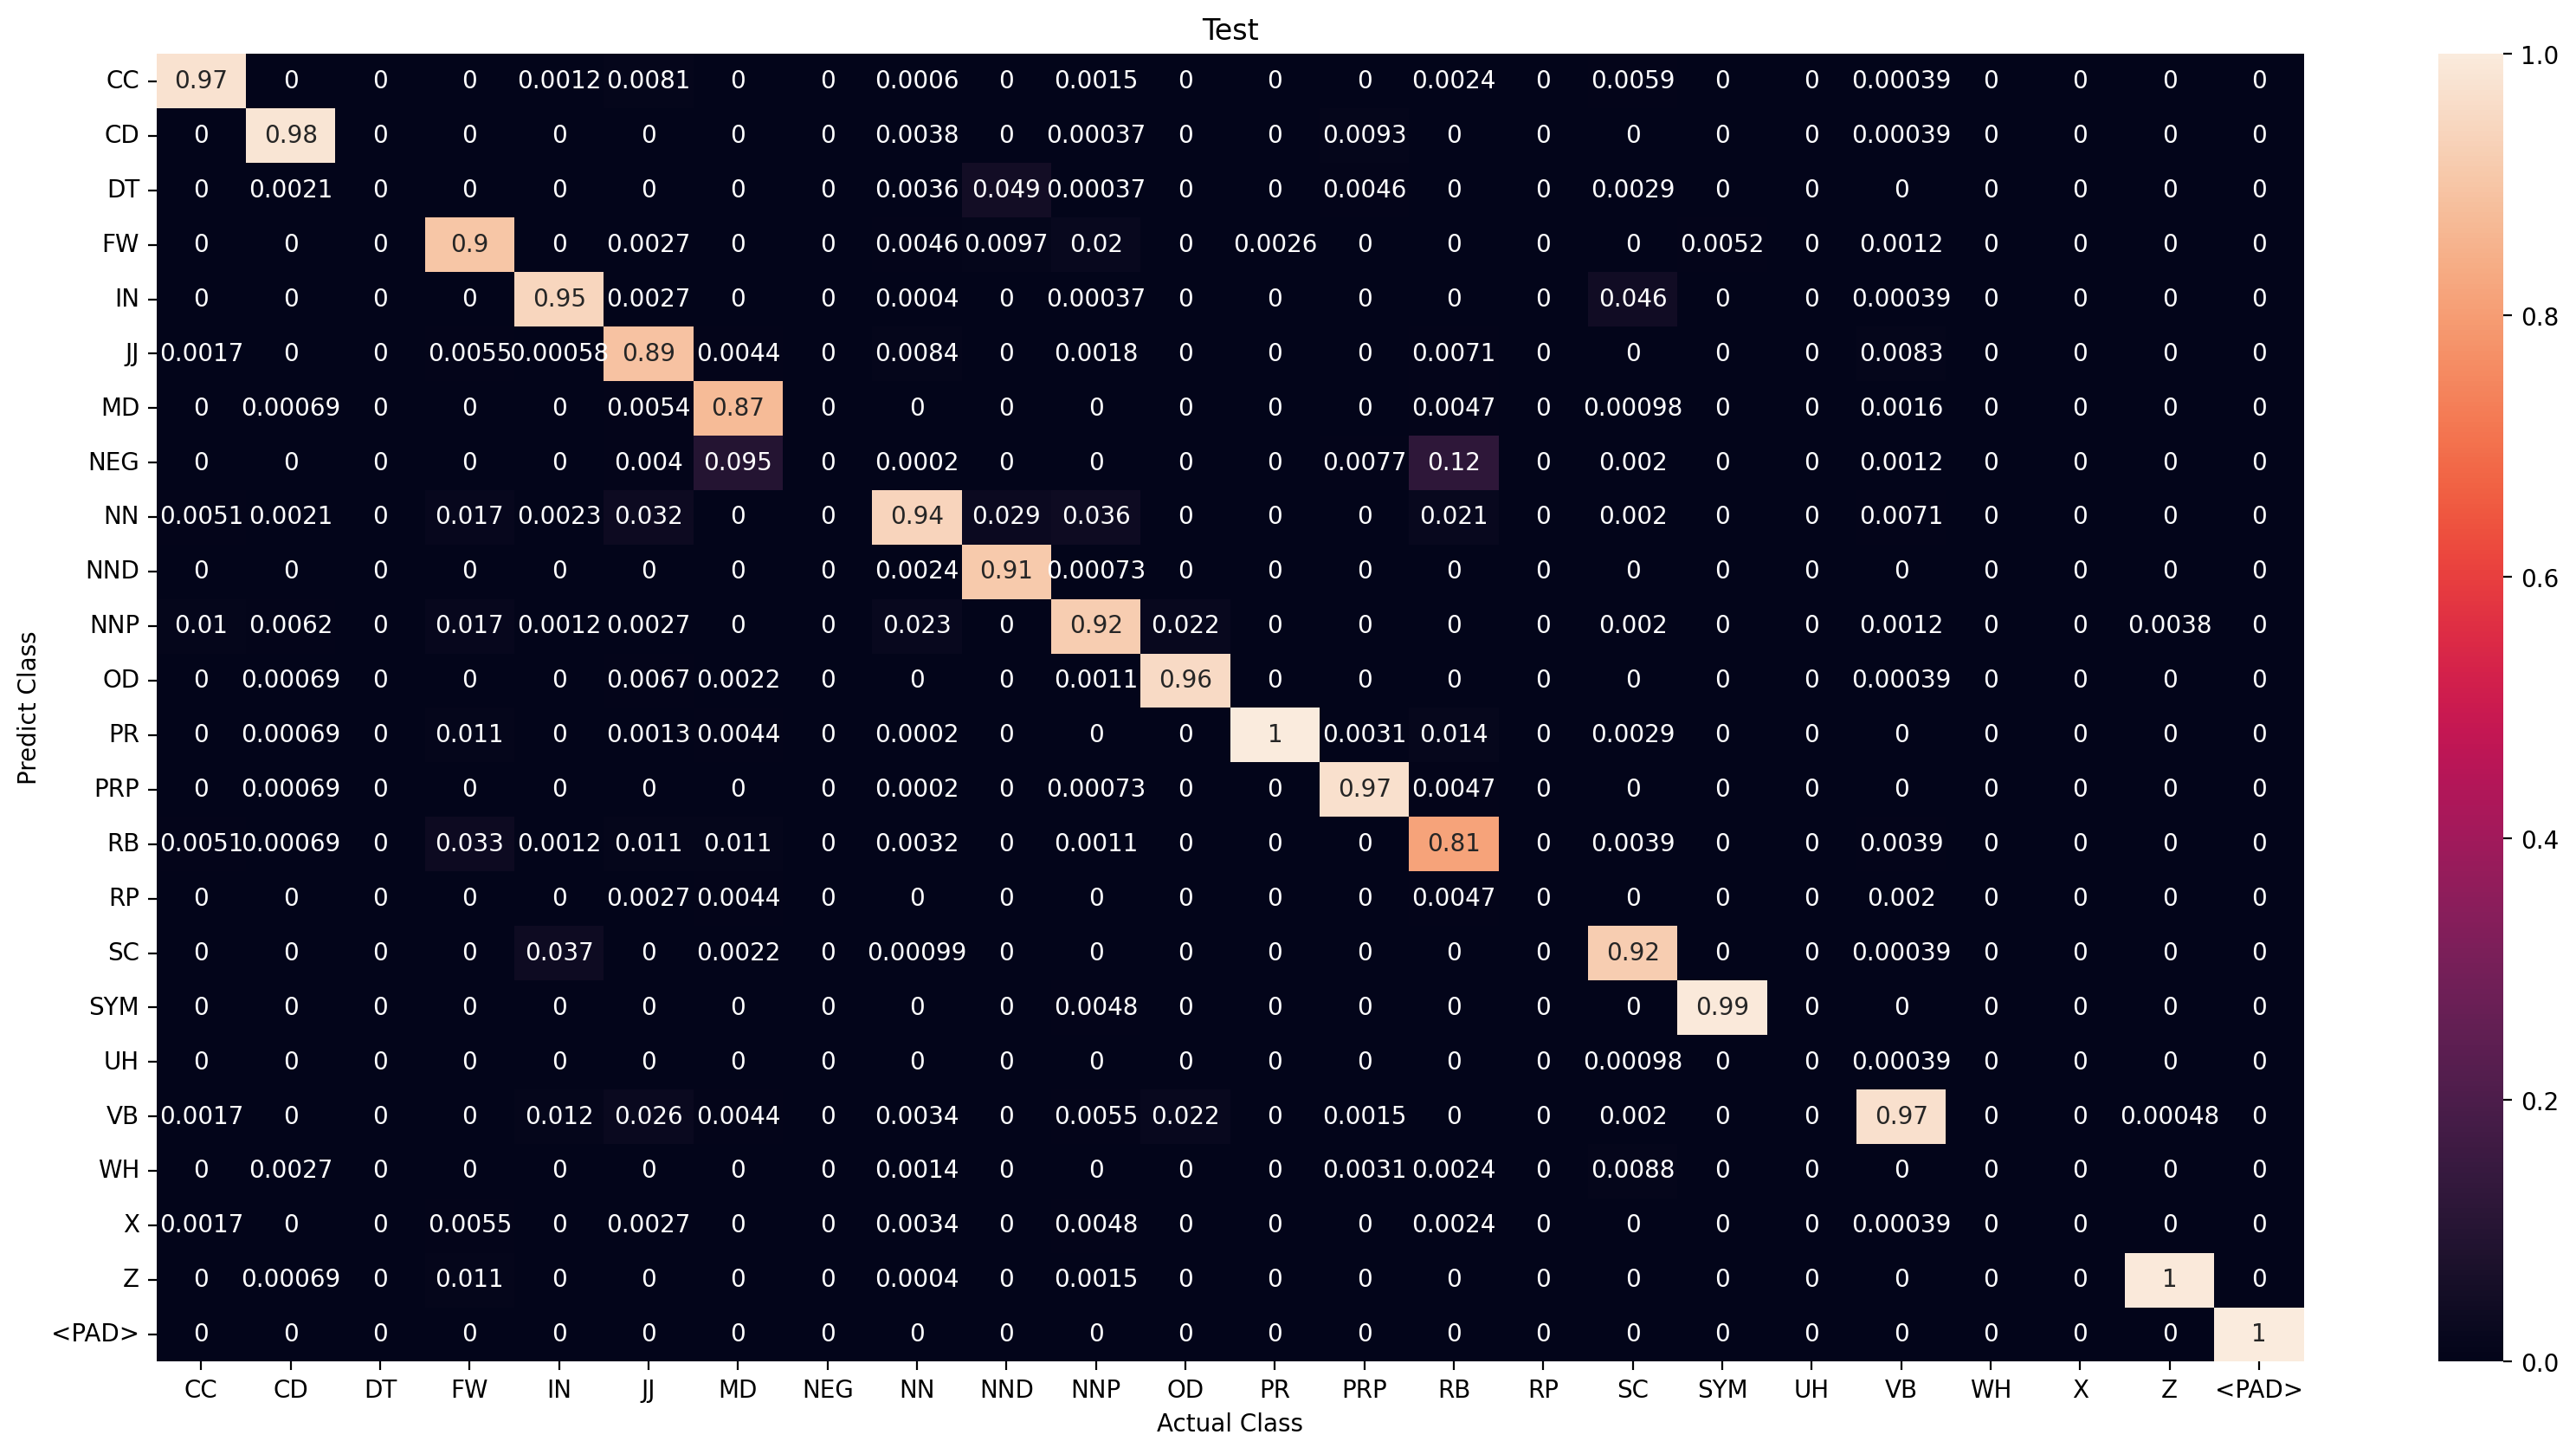

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5253       | CC    : 138      |
| CD    : 12882  | CD    : 12704      | CD    : 178      |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1483       | FW    : 207      |
| IN    : 15403  | IN    : 15280      | IN    : 123      |
| JJ    : 7018   | JJ    : 6631       | JJ    : 387      |
| MD    : 3810   | MD    : 3643       | MD    : 167      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44241      | NN    : 487      |
| NND   : 1019   | NND   : 908        | NND   : 111      |
| NNP   : 24885  | NNP   : 24469      | NNP   : 416      |
| OD    : 534    | OD    : 522        | OD    : 12       |
| PR    : 3842   | PR    : 3677       | PR    : 165      |
| PRP   : 5405   | PRP   : 5367       | PRP   : 38       |
| RB    : 3553   | RB    : 3328       | RB    : 225      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 10996
Wrong prediction            : 812
Percentage correct oov pred : 93.12330623306234

Validation
Number OOV token            : 3395
Correct prediction          : 2986
Wrong prediction            : 409
Percentage correct oov pred : 87.95287187039764

Test
Number OOV token            : 1359
Correct prediction          : 1190
Wrong prediction            : 169
Percentage correct oov pred : 87.56438557763062



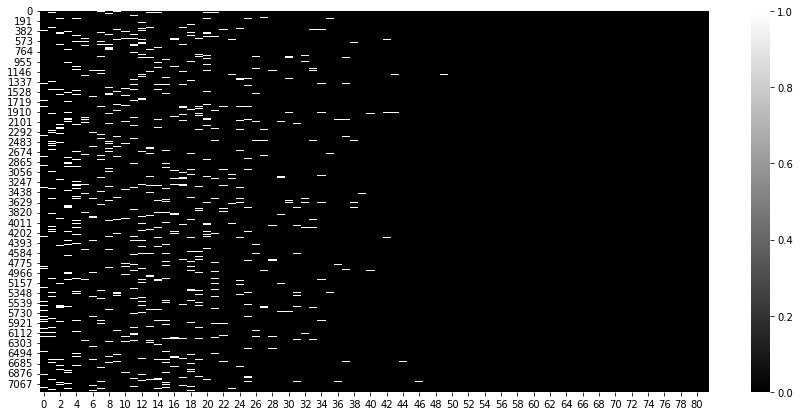

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

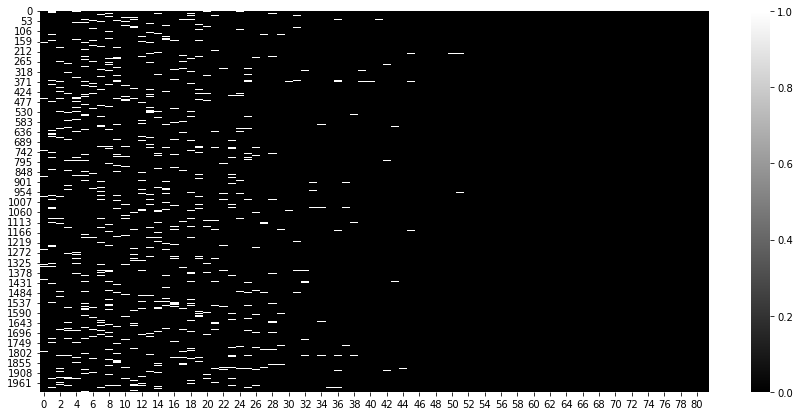

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

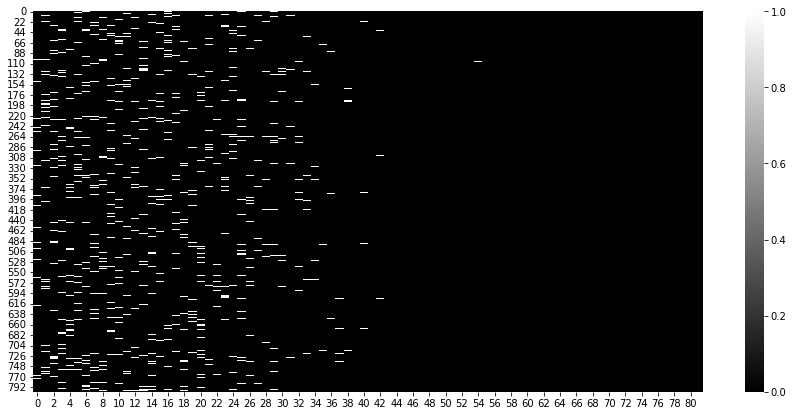

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);